# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from itertools import product as it_product

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

[example notebook: link](https://github.com/gakhov/pycon-ua-2018/blob/master/stochastic-models.ipynb)

# Parameters

In [2]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [3]:
all_data_path = r'../../data/snow_data_clean.pkl'

In [36]:
long_series_df = pd.read_pickle(all_data_path)  # TODO: fix fillna func in data cleaning notebook

def resample_by_month(df, time_col):
    """resample df on monthly basis using specified timestamp column"""
    
    # handling of time_col
    acceptable_time_col = ['timestamp', 'pseudo_ts']
    other_time_col = [x for x in acceptable_time_col if x != time_col].pop()
    if time_col not in acceptable_time_col:
        raise Exception(f'must be in {acceptable_time_col}')
    
    month = (df
             .set_index(f'{time_col}')
             .groupby([pd.Grouper(freq='1M'), 'station'])
             .agg({'base': 'mean', 'snowfall': 'sum', 
                   'region': 'first', 'state': 'first', 'ski_yr': 'first',
                   f'{other_time_col}': 'first'})
            )
    return month

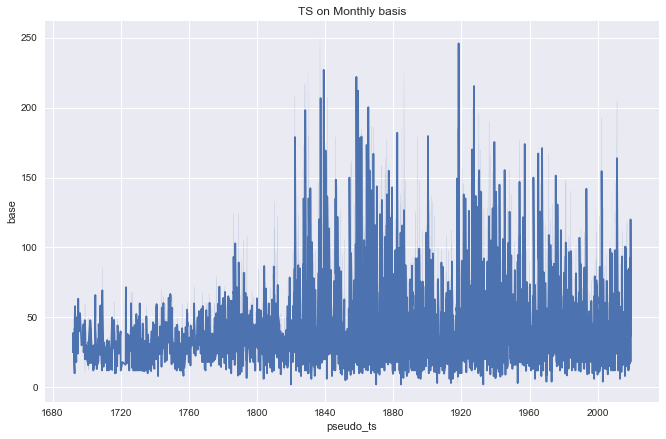

In [37]:
month_ts_df = resample_by_month(long_series_df, 'timestamp')
g = sns.lineplot(data=month_ts_df.reset_index(), x='pseudo_ts', y='base')
g.set_title("TS on Monthly basis");

In [39]:
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .reset_index()
              .query('state=="colorado"')
              [['base', 'pseudo_ts', 'station']]
              .sort_values(by='pseudo_ts')
             )
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [7]:
def AC_PAC_plotter(df=None, lags=30, differences=None):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    smg.tsaplots.plot_acf(x=df.base,
                          lags=lags, alpha=0.05,
                          use_vlines=True, unbiased=False,
                          missing='conservative',
                          title=f'Autocorrelation: Differencing: {differences}',
                          zero=True, ax=ax1
                          )
    smg.tsaplots.plot_pacf(x=df.base, lags=lags,
                           alpha=0.05, method='ldb', use_vlines=True,
                           title='Partial Autocorrelation', zero=True,
                           vlines_kwargs=None, ax=ax2)
    fig

In [8]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())

In [9]:
def y_and_yhat_plotter(model=None, endog=None, exog=None, query_filter=None, date_between=None):
    """endog should be df with time series data and pseudo_ts"""
    df = endog.copy()
    df.columns = ['y', 'pseudo_ts']
    yhat = model.fit().predict(df.values, exog)
    df['yhat'] = yhat
    if query_filter:
        df = df.query(query_filter)
    if date_between:
        df = df.loc[df.pseudo_ts.between(*date_between)]
    df = df.melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(data=df, x='pseudo_ts', y='value', hue='variable')
    plt.show();

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

In [10]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for statsmodels ARIMA models """
    def __init__(self, model_class, order, seasonal_order=None):
        self.model_class = model_class
        self.order=order
        self.seasonal_order=seasonal_order
    def fit(self, endog=None, exog=None):
        self.endog = endog
        self.exog=exog
        self.sm_model_ = self.model_class(endog=self.endog, exog=self.exog, 
                                       order=self.order, 
                                       seasonal_order=self.seasonal_order)
        self.results_ = self.sm_model_.fit()
        self.mse, self.mae = self.results_.mse, self.results_.mae
        self.bic, self.aic = self.results_.bic, self.results_.aic
        #return self.results_
    def predict(self, X):
        X = (X
             .reindex(['timestamp', 'base', 'snowfall'], axis=1)
             .set_index('timestamp'))
        return self.results_.predict(start=X.iloc[0].name, 
                                     end=X.iloc[-1].name, 
                                     exog=X.iloc[:, 2])
    def summary(self):
        return self.results_.summary()

In [11]:
def time_crossval(model, X, y):
    """takes sklearn-API model and returns CV results
    input:
        model: sklearn-API model
        X: 
        Y:
    """
    time_split = TimeSeriesSplit(8)
    cv_results = cross_validate(model, X, y, cv=time_split, 
                            scoring=['neg_root_mean_squared_error', 'r2',
                                     'neg_mean_absolute_error'], n_jobs=1) 
    return cv_results

In [12]:
def pdq_maker(order_limit=2, s_order_limit=1, period=12):
    """generate all possible SARIMA orders for range"""
    p = d = q = range(0, order_limit)
    P = D = Q = range(0, s_order_limit)
    # Generate all different combinations of pdq/PDQ triplets
    pdq = list(it_product(p, d, q))
    seasonal_PDQ = [(x[0], x[1], x[2], period) for x in list(it_product(p, d, q))]
    return (pdq, seasonal_PDQ)

def IC_chooser(unwrapped_mod=None, X=None, y=None, order_limit=(2,1)):
    """Use AIC/BIC to choose best model from grid of (pdq)(PDQ)S models
    Params:
        model:  sklearn model
        X:  
        y:
        order_limit:  tuple of highest order to use for pdq/PDQ
    Returns:
        df of AIC/BIC statistics
    """
    pdq, seasonal_pdq = pdq_maker(*order_limit)
    AIC, BIC = {}, {}
    for order in pdq:
        for season_order in seasonal_pdq:
            model = SMWrapper(unwrapped_mod, order=order, seasonal_order=season_order)
            model.fit(endog=X)
            AIC[f"{order}{season_order}12"] = model.aic
            BIC[f"{order}{season_order}12"] = model.bic
    ic_df = (pd.DataFrame.from_dict(AIC, orient='index').rename(columns={0:"AIC"})
             .merge(right=
                   pd.DataFrame.from_dict(BIC, orient='index').rename(columns={0:"BIC"}),
                   left_index=True, right_index=True)
             .sort_values(by='BIC', ascending=True)
             )
    return ic_df

## ARIMA and extensions

<Figure size 792x504 with 0 Axes>

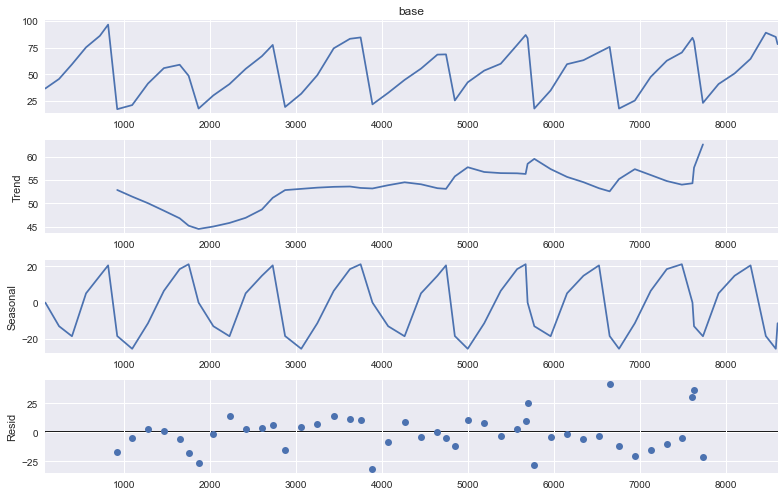

In [40]:
decomposition = smt.seasonal.seasonal_decompose(co_base_ts.query('station=="Winter Park"').base, period=12)  
fig = plt.figure()
fig = decomposition.plot();

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

In [ ]:
AC_PAC_plotter(co_base_ts)

In [ ]:
AC_PAC_plotter(co_base_ts.assign(base=lambda x:x.base.diff(periods=1)).fillna(0))

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.
I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [ ]:
# try crossvalition on model 
# (p, d, q) | (AR, diff, MA) ; 
arima_model = SMWrapper(model_class=smt.arima.model.ARIMA, 
                        order=(0, 1, 1))

arima_model_fit = arima_model.fit(endog=month_ts_df.base)
time_crossval(model=arima_model, X=month_ts_df, 
              y=month_ts_df.shift(1).fillna(0))

In [ ]:
arima_resids = pd.DataFrame(arima_model_fit.resid)
resid_plotter(arima_resids)

In [ ]:
_ = arima_model_fit.plot_diagnostics(figsize=(15, 12))

In [ ]:
IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=month_ts_df.base,  # too short but just testing
           y=month_ts_df.base.shift(1), order_limit=(2, 0))\
.applymap((lambda x : "{:,.0f}".format(x)))

there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

In [ ]:
start_d, end_d = '2004-08-01', '2006-07-30'
y_and_yhat_plotter(arima_model, co_base_ts[['base', 'pseudo_ts',]], 
                   #query_filter='pseudo_ts>@start_d & pseudo_ts<@end_d'
                  )

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [ ]:
IC_results = IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=month_ts_df.base,  # too short but just testing
                        y=month_ts_df.base.shift(1), order_limit=(2, 1))

In [ ]:
IC_results.applymap(lambda x : "{:,.0f}".format(x))

In [ ]:
sarima_model = smt.arima.model.ARIMA(endog=month_ts_df.base, order=(0, 1, 1),
                                    seasonal_order=(0, 1, 0, 12))
sarima_model_fit = sarima_model.fit()

In [ ]:
sarima_model_fit.summary()

# Regression with SARIMA Errors
Similar to ARIMAX but with more interpretable coefficients.
using snowfall data with powder -> packed powder and melt inference

In [ ]:
reg_w_sarima = smt.statespace.sarimax.SARIMAX(endog=month_ts_df.base, exog=month_ts_df.snowfall,
                                              order=(0,1,1), seasonal_order=(0,1,0,12))
reg_w_sarima_results = reg_w_sarima.fit()

In [47]:
reg_w_sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                base   No. Observations:                 8620
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood              -43519.722
Date:                             Sun, 07 Jun 2020   AIC                          87045.444
Time:                                     18:33:12   BIC                          87066.625
Sample:                                          0   HQIC                         87052.667
                                            - 8620                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
snowfall       0.4881      0.008     58.196      0.000       0.472       0.504
ma.L1         -0.9997      0.002   -539.096      0.000      -1.003      -0.996
sigma2      1518.7913     14.161    107.251      0.000    1491.036    1546.547
===================================================================================
Ljung-Box (Q):                     2131.42   Jarque-Bera (JB):              5238.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.02
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
reg_w_sarima_results.predict(endog=month_ts_df.base, exog=month_ts_df.snowfall,)

timestamp   station                    
2010-11-30  49 Degrees North               12.201448
            Afton Alps                     22.181725
            Alpental                       38.083817
            Alpine Valley                  10.683614
            Alta                           64.578134
                                             ...    
2019-07-31  Arapahoe Basin                 56.127852
            Mammoth Mountain               23.781708
            Snowbird                       98.312809
            Squaw Valley Alpine Meadows    75.989387
            Timberline Lodge               46.199519
Length: 8620, dtype: float64

In [ ]:
y_and_yhat_plotter(model=reg_w_sarima, endog=month_ts_df.base, exog=month_ts_df.snowfall,)

In [93]:
snow_beta_df = (pd.DataFrame({'station': ['test'], 'beta': [0], 'region': ['test']})
                .drop(index=0))  # avoid pd forcing region column to numeric
month_reset = month_ts_df.reset_index().set_index('timestamp')
for station in month_reset.station.unique():
    station_df = month_reset[month_reset.station==station]
    reg_w_sarima = smt.statespace.sarimax.SARIMAX(endog=station_df.base, 
                                                  exog=station_df.snowfall,
                                                  order=(0,1,1), 
                                                  seasonal_order=(0,1,0,12))
    results = reg_w_sarima.fit()
    snow_beta_df.at[station, 'beta'] = results.params.snowfall
    snow_beta_df.at[station, 'region'] = station_df.region[0]

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\base\tsa_

LinAlgError: Non-positive-definite forecast error covariance matrix encountered at period 14

In [89]:
snow_beta_df.head()

,station,beta,region
0,test,0.000000,test
49 Degrees North,NaN,-0.036645,Cascades
Afton Alps,NaN,0.201750,Other
Alpental,NaN,-0.013658,Cascades
Alpine Valley,NaN,1.382303,Other


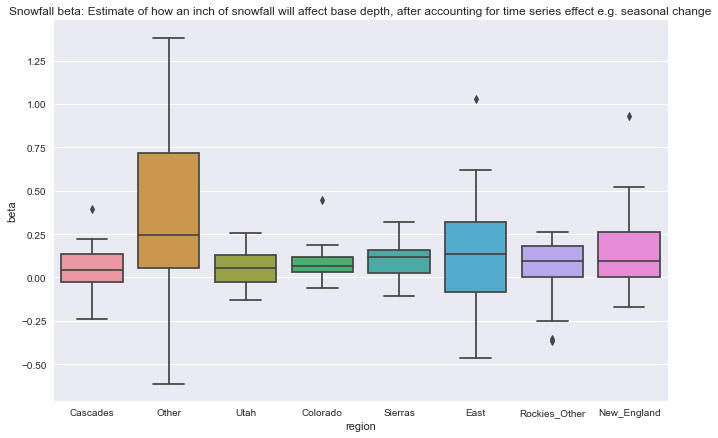

In [96]:
sns.boxplot(data=snow_beta_df, x='region', y='beta')
plt.title('Snowfall beta: Estimate of how an inch of snowfall will affect base depth, after accounting for time series effect e.g. seasonal change');

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb), 

### Panel Models
Linearmodels module?